## Basic Transit Light Curve Fits

This notebook will walk you through the basics of transit light curve fitting with exoUPRF.

First let's open up some light curves to fit. Here, we're going to use the JWST NIRISS/SOSS transit white light curve of WASP-39b from the observations published in [Feinstein & Radica et al. (2023)](https://ui.adsabs.harvard.edu/abs/2023Natur.614..670F/abstract) as part of the JWST Transiting Exoplanet Community Early Release Science Program.

In [2]:
import numpy as np

# Load the white light curve data

t, wlc = np.load('../data/WASP-39b_WhiteLight.npy')
wlc /= np.median(wlc[:100])  # Normalize the light curve by the out-of-transit baseline.

Let's take a look at the white light curve.

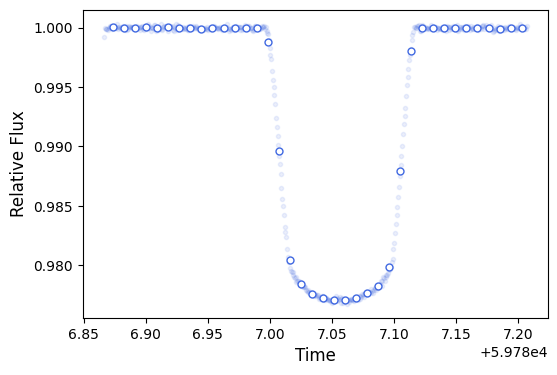

In [3]:
import matplotlib.pyplot as plt

# Temporally bin the light curve for display purposes. 

tbin = np.mean(np.reshape(t[5:], (38, 14)), axis=1)
wbin = np.mean(np.reshape(wlc[5:], (38, 14)), axis=1)

# Plot the raw and binned white light curves. 

plt.figure(figsize=(6, 4))
plt.errorbar(t, wlc, fmt='o', c='royalblue', alpha=0.1, ms=3)
plt.errorbar(tbin, wbin, fmt='o', mec='royalblue', mfc='white', ms=5)

plt.xlabel('Time', fontsize=12)
plt.ylabel('Relative Flux', fontsize=12)
plt.show()

Two things to note here (other than how clean, precise, and continuous the light curve is...I mean just compare it to Figure 2 in [Wakeford et al. (2018)](https://ui.adsabs.harvard.edu/abs/2018AJ....155...29W/abstract)!). 

First, is the fact that we don't have any errors associated with the flux values. This is perfectly fine. Pipelines will generally spit out flux error values for you, and you can feel free to use those. However, it is best practice to always include an error inflation term in your light curve fits. This basically will inflate the errors on the flux measurements such that the light curve model has a reduced chi-sqaured of unity. Basically, we're going to let the fit tell us what our flux errors should be, instead of us telling it to the fit!

Secondly, this light curve is for SOSS order 1, but we generally analyze the first spectral orders for SOSS. We're just going to work with order 1 in this tutorial for simplicity. Generally though, I prefer to jointly fit the white light curves for orders 1 and 2. This should be straightforward for you to do after working through this tutorial, but if you have doubts, you can refer to [Radica et al. (2024)](https://ui.adsabs.harvard.edu/abs/2024ApJ...962L..20R/abstract) for more information on what parameters to share between orders, etc. 

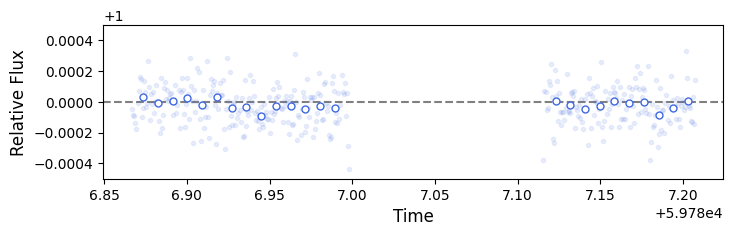

In [4]:
# Zoom in to the out-of-transit baseline to see if there are any sysmtematic trends. 

plt.figure(figsize=(8, 2))
plt.errorbar(t, wlc, fmt='o', c='royalblue', alpha=0.1, ms=3)
plt.errorbar(tbin, wbin, fmt='o', mec='royalblue', mfc='white', ms=5)

plt.xlabel('Time', fontsize=12)
plt.ylabel('Relative Flux', fontsize=12)
plt.ylim(0.9995, 1.0005)
plt.axhline(1, ls='--', c='grey', zorder=-1)
plt.show()

There are some wiggles there, but overall the amplitudes are quite small. We'll likely be perfectly fine just using a very simplistic systematics model. 

Now let's set up the fit.  
Most fits will have two model components: an astrophysical model and a systematics model. The astrophysical model generally contains the science quantities that we're interested in. In this case, our astrophysical model will be a transit model, from which we extract the planet's transit depth and other orbital parameters.  
The systematics model, on the other hand, takes care of everything else that might be impacting the light curve. This could include correlated detector noise, systematic detector trends, or astrophysical noise quantities like star spot crossings or stellar activity. In this case, the light curve actually looks quite clean (as we saw in the plot above). We'll therefore use a very simplistic systematics model or just a linear slope with time, as was done in [Feinstein & Radica et al. (2023)](https://ui.adsabs.harvard.edu/abs/2023Natur.614..670F/abstract).

For those of you familiar with the [juliet](https://juliet.readthedocs.io/en/latest/) library, the syntax for initializing fits will be quite familiar. Indeed, I've based the this on juliet as I find its syntaxes and set up to be very intuitive.  

The general syntax for fitted parameters is: "parameter name" _ "planet" _ "instrument". This means parameters can generally be fit to multiple planets in a given dataset, or simultaneously across multiple instrument datasets for a given planet.  

First let's determine which parameters we want to include in the fitted model.

In [5]:
parameters = [
    
    # Start with astrophysical model parameters. 
    # We're fitting the transit of WASP-39b, so we only expect to have one planet in our dataset.
    # We denote this with the tag "p1".
    
    'per_p1',       # Planet orbital period. 
    't0_p1',        # Time of mid-transit.
    'a_p1',         # Planet orbital semi-major axis as a/R*. 
    'inc_p1',       # Planet orbital inclination in degrees.
    'ecc_p1',       # Planet orbital eccentricity.
    'w_p1',         # Planet argument of periastron in degrees.
    
    # Some astrophysical quantities can be wavelength dependent. The orbital parameters are 
    # not -- it doesn't matter at what wavelength you measure the period, it will always be the 
    # same. Quantities like the transit depth and limb darkening though will vary with waveband.
    # We therefore tack on an instrument tag to waveband dependent parameters. This is 
    # especially useful if we want to fit these parameters independently across multiple 
    # instrument datasets. 
    
    'rp_p1_SOSS',   # Planet transit depth as Rp/R* in SOSS waveband.
    'u1_SOSS',      # First parameter of quadratic limb darkening law in SOSS waveband. 
    'u2_SOSS',      # Second parameter of quadratic limb darkening law in SOSS waveband. 
    
    # Now we handle the systematics model parameters. These are generally instrument, but not 
    # planet dependent. 
    
    'sigma_SOSS',   # Error inflation term for SOSS instrument. 
    'zero_SOSS',    # Transit zero point for SOSS instrument. 
    'theta1_SOSS'   # Linear slope with time for SOSS instrument.
             ]

Now we select which prior distribution we want to use for each parameter. Options are 'uniform', 'log-uniform', 'normal', or 'truncatednormal' for fitted parameters, or 'fixed' for a fixed parameter. We'll fix the orbital period, eccentricity, and argument of pericenter, and use wide, uniformative priors for everything else.  
Note: each parameter needs to have an associated prior distribution, even if it's not being fit.

In [6]:
distributions = ['fixed',       # per_p1
                 'uniform',     # t0_p1
                 'uniform',     # a_p1
                 'uniform',     # inc_p1
                 'fixed',       # ecc_p1
                 'fixed',       # w_p1
                 'uniform',     # rp_p1_SOSS
                 'uniform',     # u1_SOSS
                 'uniform',     # u2_SOSS
                 'loguniform',  # sigma_SOSS 
                 'uniform',     # zero_SOSS 
                 'uniform'      # theta1_SOSS 
                ]

Now, we need to select the prior hyperparameters for each quantity. These represet the values to which we will set fixed parameters, and the bounds of priors for fitted parameters.

In [7]:
values = [4.055259,              # per_p1
          [59786.95, 59787.15],  # t0_p1
          [5, 40],               # a_p1
          [85, 90],              # inc_p1
          0,                     # ecc_p1
          90,                    # w_p1
          [1e-2, 0.9],           # rp_p1_SOSS
          [-1, 1],               # u1_SOSS
          [-1, 1],               # u2_SOSS
          [1e-6, 1e-1],          # sigma_SOSS 
          [-1e-3, 1e-3],         # zero_SOSS 
          [-1, 1]                # theta1_SOSS 
         ]

And finally, we'll pack everything into a dictionary so that it can be fed into a fit!

In [8]:
inputs = {}
for param, distribution, value in zip(parameters, distributions, values):
    inputs[param] = {}
    inputs[param]['distribution'] = distribution
    inputs[param]['value'] = value

The final thing we need to do before starting the fit is pack up the data that we want to fit into the format that exoUPRF expects. As with the prior information, this takes the form of dictionaries.  
We'll need to pass a dictionary containing the light curve flux for each instrument, as well as another dictionary with the timestamps corresponding to the flux measurements for each instrument. If you're fitting linear models or GP models, you'll also need dictionaries of regressors for each instrument. Finally, you'll need one more dictionary telling exoUPRF which model you want to fit to each dataset. 

In [9]:
# Initialize the time stamps dictionary. We only have one instrument, so only one key is 
# necessary. 

time = {'SOSS': t}

# Intialize the dictionary of observations.

obs = {'SOSS': {'flux': wlc}}

# Initialize the dictionary of models to fit. Here we also want to specify a model for each 
# planet. Once again, we are only fitting one simgle planet in this dataset. 
# We also select a simple batman transit model for this purpose with the keyword 'transit'.

model_type = {'SOSS': {'p1': 'transit'}}

# Initialize the dictionary of regressors with which we will fit the slope with time.

regressors = {}
rr = np.zeros((1, len(time['SOSS'])))
rr[0] = (time['SOSS'] - np.mean(time['SOSS']))/np.var(time['SOSS'])
regressors['SOSS'] = rr

Now we have everything we need to start a fit!  
The main class for this purpose in exoUPRF is the ```Dataset``` class in the ```fit``` module. Let's initialize it now by passing all the dictionaries we created above. Since we're fitting a simple transit model, we also need to indicate which limb darkening law we're going to use -- in this case the quadratic law. 

In [10]:
import exouprf.fit as fit

dataset = fit.Dataset(inputs, t=time, ld_model='quadratic', linear_regressors=regressors,
                      observations=obs, lc_model_type=model_type)

We then run the fit using the ```fit``` method. We need to specify the name of an output file to which we will save the fit outputs, as well as choose which sampler we want to use. Currently, the two options are "NestedSampling" with [dynesty](https://dynesty.readthedocs.io/en/stable/) or "MCMC" with [emcee](https://emcee.readthedocs.io/en/stable/). This fit shouldn't take too long to run, less than five minutes or so. 

In [11]:
dataset.fit(output_file='WASP-39b', sampler='NestedSampling', force_redo=False)

35572it [03:26, 172.61it/s, +500 | bound: 455 | nc: 1 | ncall: 999679 | eff(%):  3.610 | loglstar:   -inf < 4057.743 <    inf | logz: 3987.226 +/-  0.373 | dlogz:  0.001 >  0.509]


A corner plot is a useful way to visualize the posterior distributions for fitted parameters.

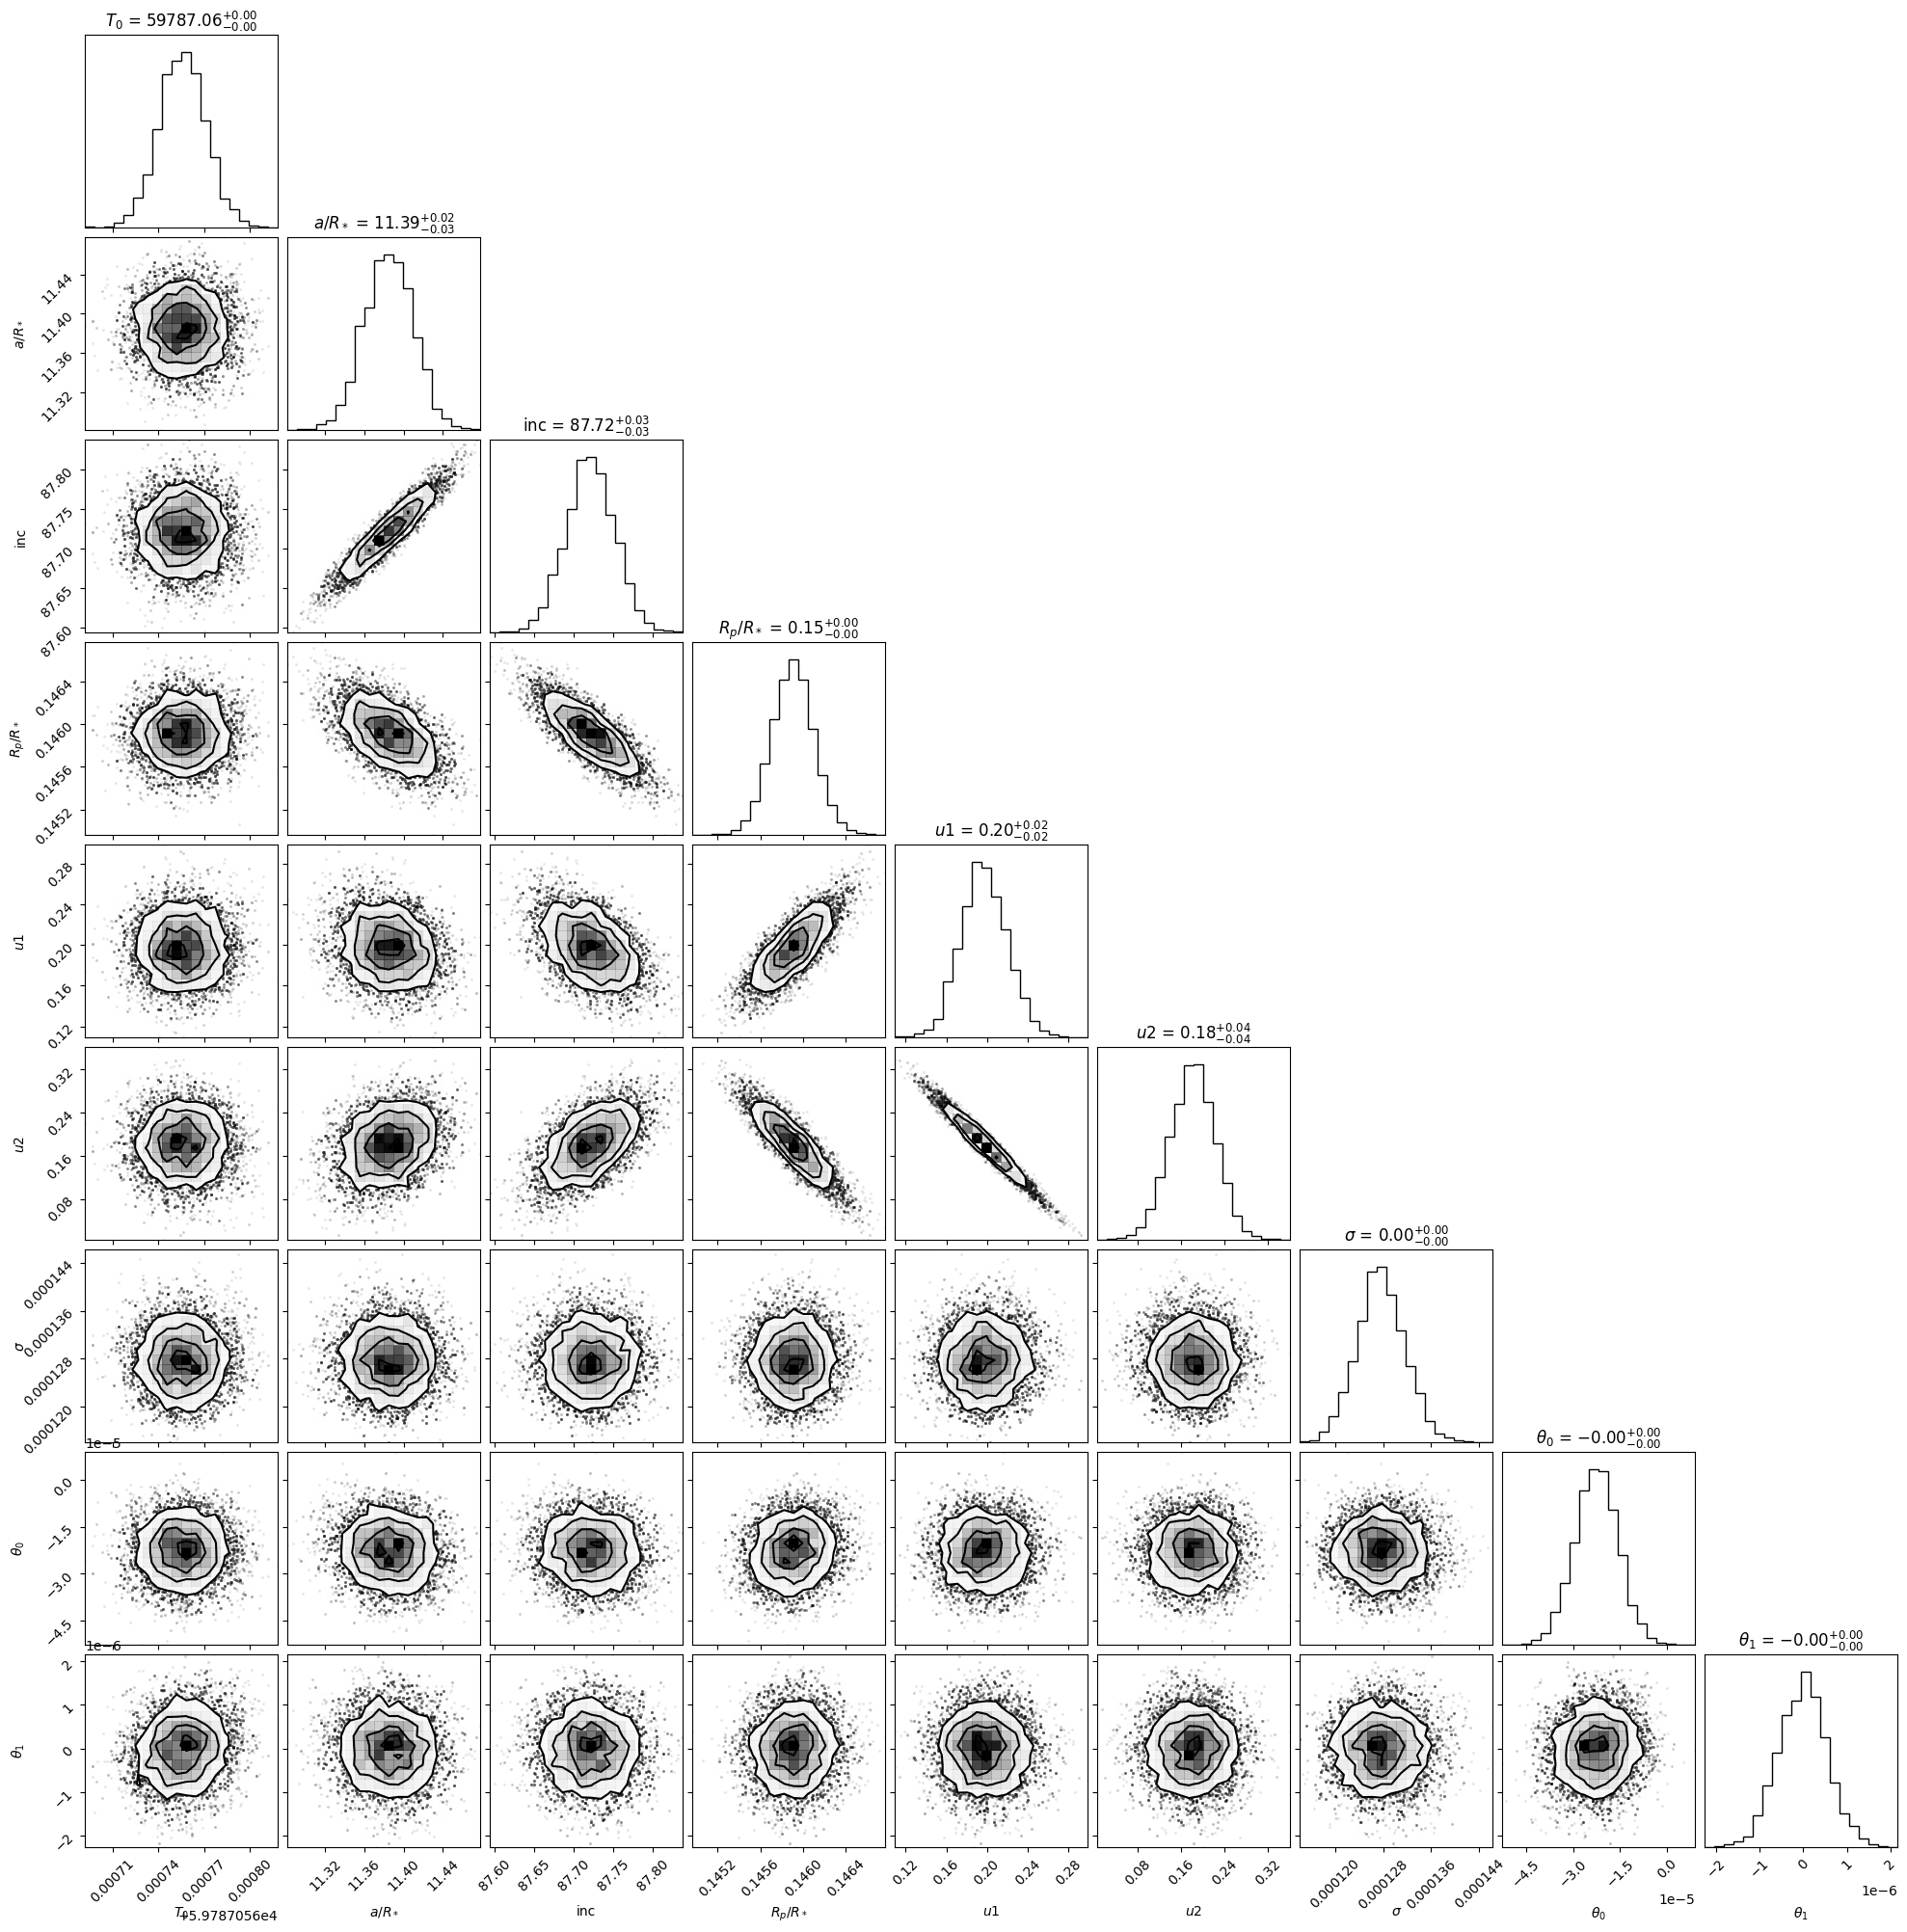

In [12]:
# Formatted names of fitted parameters.

labels = [r'$T_0$', r'$a/R_*$', r'inc', r'$R_p/R_*$', r'$u1$', r'$u2$',  
          r'$\sigma$', r'zero point', r'$\theta_1$']

# And now make the corner plot!

dataset.make_corner_plot(labels=labels)

Now let's extract the best fitting solutions. We can then use exoUPRF's major backend class ```LightCurveModel``` in order to visualize the solution. 

```LightCurveModel``` takes an input parameter dictionary very similar to the one that we prepared for the fit above, except it doesn't need any information on priors. Instead of extracting all the best-fitting values and manually reconstructing a parameter dictionary, exoUPRF has a functionality that will automatically do that for us!

In [13]:
# Create a parameter dictionary directly from the completed fit. 

param_dict = dataset.get_param_dict_from_fit()

2024-06-27 12:14:52.136 - exoUPRF - INFO - Importing fitted parameters from file WASP-39b.h5.


The ```param_dict``` dictionary has a key for each parameter in the fit (irrespective of whether it was fitted or fixed). It also stores the value to which the parameter was fixed, or, in the case of fitted parameters, the median of its posterior distribution.

In [14]:
# For example, the best-fitting mid-transit time is....

print('{:.4f}'.format(param_dict['t0_p1']['value']))

59787.0568


We can also get the best-fitting values and 1-sigma error envelopes with the ```get_results_from_fit()``` method.

In [15]:
results_dict = dataset.get_results_from_fit()

2024-06-27 12:14:52.152 - exoUPRF - INFO - Importing fit results from file WASP-39b.h5.


In [16]:
# For example, the best-fitting mid-transit time and its 1-sigma error envelope are...

med = results_dict['t0_p1']['median']
low_1sig = results_dict['t0_p1']['low_1sigma']
up_1sig = results_dict['t0_p1']['up_1sigma']
print('t0_p1 = {0:.4f} -{1:.3e} +{2:.3e}'.format(med, low_1sig, up_1sig))

t0_p1 = 59787.0568 -1.490e-05 +1.497e-05


We now initialize the ```LightCurveModel``` with the same inputs that we used for the ```fit``` class above, except we now pass our new param_dict.

In [17]:
import exouprf.light_curve_models as model

result = model.LightCurveModel(param_dict, t=time, ld_model='quadratic', 
                               linear_regressors=regressors, observations=obs)

# Calculate light curve model with our fitted parameters!

result.compute_lightcurves(lc_model_type=model_type)

2024-06-27 12:14:52.171 - exoUPRF - INFO - Importing parameters for 1 planet(s) from instrument SOSS.
2024-06-27 12:14:52.171 - exoUPRF - INFO - Computing light curves for all instruments.
2024-06-27 12:14:52.171 - exoUPRF - INFO - Linear model(s) detected for instrument SOSS.


Now let's plot everything up and see how our fit looks. There's a couple of quantities we need to prepare beforehand though...

In [18]:
# Get the best-fitting time of mid-transit.

t0 = results_dict['t0_p1']['median']

# Calculate a rough estimate of the scatter in the baseline flux. This is to estimate how our 
# fitted light curve scatter compares to the scatter in the data. 

out_dev = np.nanstd(obs['SOSS']['flux'][:100])

# If we've fitted any systematics model, we might also want to see what the light curve looks 
# like when corrected for systemaics. To get the systematics model, we just subtract the planet 
# model from the total model.

sys = result.flux_decomposed['SOSS']['total'] - result.flux_decomposed['SOSS']['pl']['total']

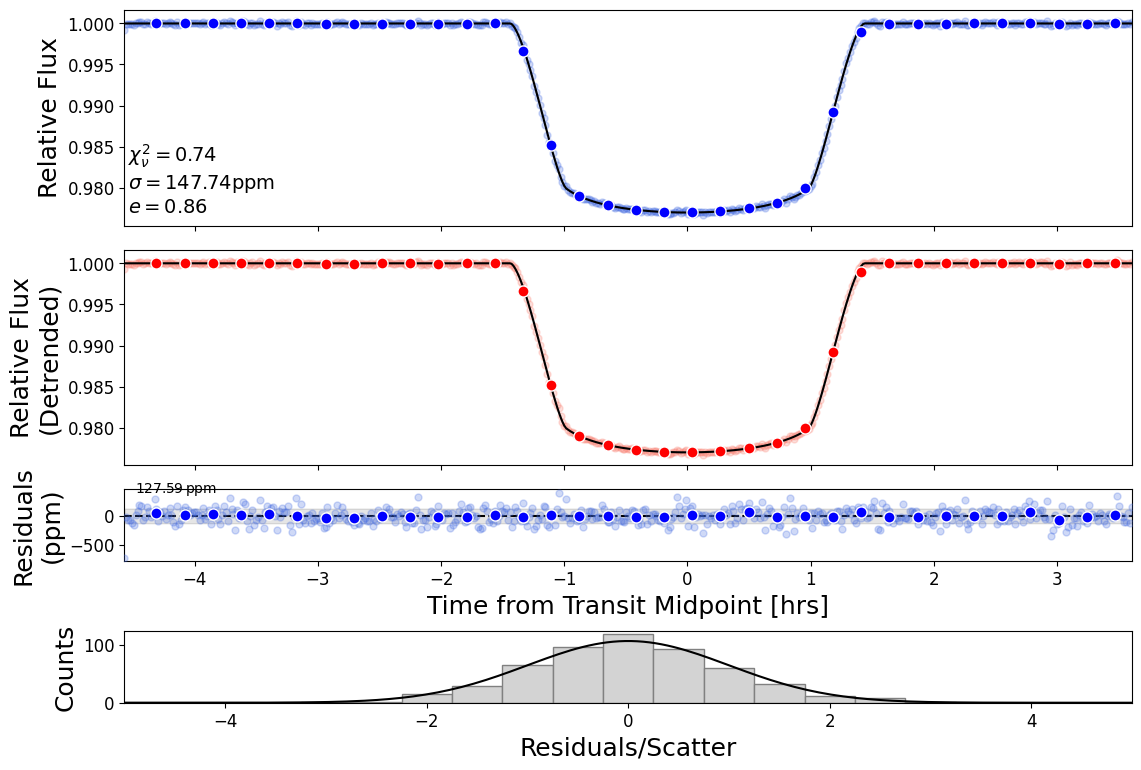

In [19]:
# And finally plot everything up.

import exouprf.plotting as plotting

plotting.make_lightcurve_plot((time['SOSS']-t0)*24, obs['SOSS']['flux'], result.flux['SOSS'], 
                              scatter=param_dict['sigma_SOSS']['value'], 
                              errors=out_dev, systematics=sys, nfit=9, nbin=15)

The top panel shows the raw light curve data in blue (dark blue points are binned in time for visualization purposes) with the best fitting total model (that is astrophysical + systematics) in black. 
In the second panel, the systematics-corrected light curve is shown in red, with the best-fitting planet model in black. Here there isn't much difference between the two because there really weren't a lot of systematics to correct! 
The third panel shows the fit residuals, and the bottom panel has a histogram of the fit residuals. If we've adequantely fit the data, we should expect the histogram to trace the black Gaussian curve -- which it does!

And there you have it, you're now ready to tackle the wide world of fitting light curves! *Have fun!*